In [1]:
# ----- NOTES -----
# - pg.85: most common supervised learning tasks are regression and classification
# - in this chapter we are using the MNIST dataset, what is this?
# - pg.86: what is the typical dictionary structure for sklearn datasets
# - pg.86: what does matplotlib's imshow() method do?
# - pg.86: what is a feature vector?
# - why does some_digit = X[0] not work?
# - pg.86: how to turn the label from string to integer and why would we do that
# - pg.87: why is shuffling a dataset important
# - pg.88: what is a binary classifier?
# - pg.88: what is stochastic gradient descent (SGD)?
# - pg.88: why is SGD have advantage on large datasets and good for online learning
# - why might you need to turn a data set into an array when testing?
# - pg.88: why might a classifier be more difficult to measure performance than
# a regressor?
# - pg.90: why is accuracy not a preferred performance measure of classifiers?
# - pg.90: what is a confusion matrix
# - pg.90: what is a k-fold
# - pg.91: note the precision equation and what it's used for and how.
# - pg.91: why is 'recall' used with 'precision'
# - pg.91: what is the recall equation and what are its other names?
# - pg.92: confusion matrix explained
# - pg.92: what is called when you combined recall and precision
# - pg.93: why might you want to use a recall or precision over another?
# - pg.93: what trade-offs does precision and recall have?
# - pg.94: understand the graph.
# - pg.94: how do you decide which threshold to use?
# - pg.94: what does 'precision_recall_curve()' function compute
# - pg.95: what does [:-1] mean
# - pg.95: understand the graph on this page fig 3-4

In [39]:
# ----- IMPORTS -----
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score
from sklearn.base import BaseEstimator
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve

In [3]:
# here we are fetching the MNIST dataset
# DECSR key - describing the dataset
# data key - contains an array with one row per instance and one column per feature
# target key - containing an array with labels
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [4]:
# looking at these arrays
X, y = mnist["data"], mnist["target"]

In [5]:
# this means there are 7,000 images and 784 features
# it's 784 because its 28 by 28 pixels, and each feature represents
# one pixels intensity
X.shape

(70000, 784)

In [6]:
#label
y.shape

(70000,)

In [7]:
28 * 28

784

In [8]:
# here we are grabbing a feature vector and reshaping into a 28x28 array
# we then display it using matplotlib's imshow() function
# -----
# taking the first instance of mnist['data']
# instead of some_digit = X[0] use the below
some_digit = X.to_numpy()[0]
# reshaping it into an 28x28 array
some_digit_image = some_digit.reshape(28, 28)

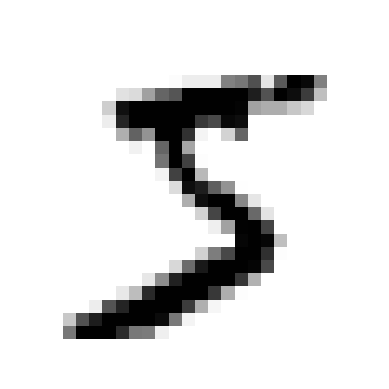

In [9]:
# --- plotting
#  colormap instance or registered colormap name = cmap
# X shows the instance, while y shows the value
plt.imshow(some_digit_image, cmap='binary')
plt.axis('off')
plt.show()

In [10]:
y[0]

'5'

In [11]:
# note: that the label is a string (y[0]=5) but most algorithms expect numbers
# here we are going to cast y as to an integer
y = y.astype(np.uint8)

In [12]:
# splitting the dataset for testing and training.
# the data is already split into training (first 60,000) and test (last 10,000)
# the training set is already shuffled for us
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [13]:
# for now we are only going to try to identify one digit, for example '5'
# this '5-detector' will be an example of a binary classifier
# this would be capable of distinguishing between just two classes. 5 and not 5
y_train_5 = (y_train == 5) # True for all 5's, false for all other digits
y_test_5 = (y_test == 5)

In [14]:
# a good classifier to begin with is SGD classifier
# this classifier has the advantage of being capable of handling very large
# datasets efficiently.
#---
# SGDClassifier relies on randomness (hence stochastic)
sgd_clf = SGDClassifier(random_state=42)
X_train = X_train.values # conversion of X_train into an array
# above ^ is done to turn it into an array because you get a warning.
# this is because X_train is fitted as a model but tested as an array.
# to solve the warning I turn it into an array
sgd_clf.fit(X_train, y_train_5) # using X_train dataset to train if it's 5 or not

SGDClassifier(random_state=42)

In [15]:
sgd_clf.predict([some_digit]) # if we remember from earlier, some_digit is the
                              # number [0] and it equals 5
# the model guessed correctly, now to determine its performance

array([ True])

In [18]:
# a good way to evaluate a model is using cross-validation
# below we can see the accuracy across all three folds,they are all above 95%
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

In [21]:
# here we are going to look at a classifier that only looks at the not 5's
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [22]:
# determining the accuracy of the above class
# all are above 90%, only about 10% of number are 5's
# this is why accuracy is not a good performance measure for classifiers
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.91125, 0.90855, 0.90915])

In [25]:
# a better performance measure for classifiers is the confusion matrix
# an example how this works: it counts the number of times the classifier
# confused images of 5's with 3's.
# -----
# to compute the confusion matrix we first need to have a set of predictions on the test set
# -----
# to begin we can start with cross_val_predict
# --- explain what's happening this this code:
# performs a k-fold
# uses the SGDClassifier
# X_train data set with with the test to equal True if it's 5
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [27]:
# now to use the confusion matrix
# each row in the confusion matrix represents an actual class
# each column represents the predicted class
# ---
# (negative class)
# the first row (53892) were correctly classified as non-5s (called True negatives)
# the second (687) are wrongly classified (called false positive)
# (positive class)
# (1891) was wrongly classified as non-5's (false negatives)
# (3530) were correcly classified (True positive)
# ---
# the first column is testing negatives and the second column is testing positives
# the first row is testing not 5s and second row is testing for 5s
# this mean top left is a True negative because it correctly predicted non 5s
# top right incorrectly predicted non 5s
# ---
# positive (second column) = seen as 5's
# negative (first column) = seen as non's
# first row = results for testing non 5s
# second row = results for testing 5s
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

In [28]:
# a perfect matrix would only have true positive and true negatives
# on the confusion matrix would have non-zero values only on its main diagonal
#---
# this is example it being tested against it's own training set
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

In [ ]:
# UNDERSTANDING THE CONFUSION MATRIX
# seek pg.92

In [30]:
# sklearn provides functions for precision and recall
# this creates a precision score of this classifier
# it's 83.7% accurate, it's get this by dividing it's actual positives
# by it's total positive
precision_score(y_train_5, y_train_pred) # 3530/(3530 + 687)

0.8370879772350012

In [31]:
# 65.1% accurate, dividing a true positives by false negative + true positive
recall_score(y_train_5, y_train_pred) # 3530/(3530 + 1891)

0.6511713705958311

In [33]:
# computing the f1 score
# f1 favors similar precision and recall, however this is always what you want
# this is exlpained on pg.93
f1_score(y_train_5, y_train_pred)

0.7325171197343846

In [34]:
# to understand the trade-off we can look at the SGDClassifier and 
# how it makes classification decisions
# -----
# Sklearn doesn't give you access to set the threshold directly, but it does
# give decision scores which is used to make predictions.
# instead of calling the predict() method you can call decision_function()
# this method returns the score for each instance, then using any threshold you
# want to make predictions based on those scores.
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [36]:
# we can change the threshold which can decrease/increase recall
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [37]:
threshold = 3000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [38]:
# deciding which threshold to use
y_score = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                           method='decision_function')

In [55]:
# using precision_recall_curve() to precision and recall for possible threholds
# finding the threshold where 5 is True out of the y train set
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_score)

# using matplotlib to plot precision and recall as functions
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label='Precision', linewidth=3)
    plt.plot(thresholds, recalls[:-1], 'g-', label='Recall', linewidth=3)
    plt.xlabel('threshold', fontsize=16)
    plt.legend(loc='upper left', fontsize=16)
    plt.ylim([0, 1])
    # [...] highlight the threshold and add the legend, axis label, and grid

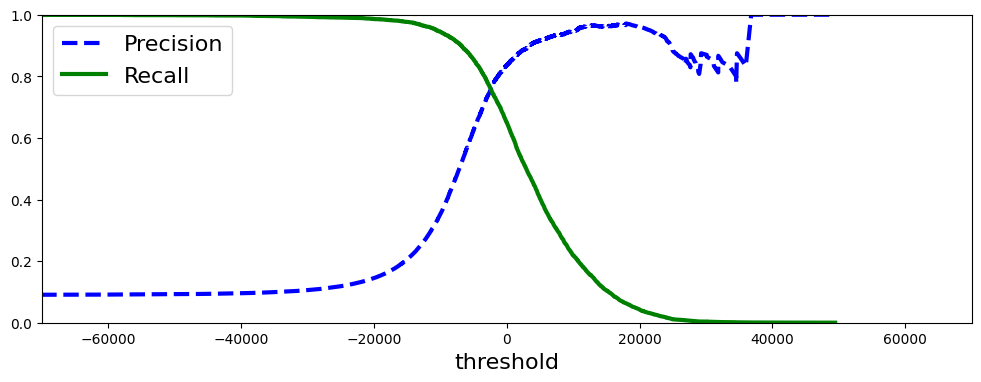

In [56]:
plt.figure(figsize=(12,4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.xlim([-70000, 70000])
plt.show()
"""
The reason why the precision curve is bumpier is because the precision
may go down when you raise the threshold. though in general it goes up.
An other example would be figure 3-3, if you increased the threshold you would
see precision to go from 4/5(80%) to 3/4(75%), on the other hand recall can 
only decrease.
"""